# Mutation Risk

In [70]:
from utils import analysis, plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
import importlib
importlib.reload(plotting)

burn_in = 0.2

In [54]:
data_name = "G13_COAD_12"

samples = np.load("../results/mcmc/G13_LUAD_12_sym-l2_MALA_0_0015625.npy" if data_name == "G13_LUAD_12"
                  else "../results/mcmc/G13_COAD_12_symsparse_MALA_0_001.npy")[:, ::10]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv")

In [55]:
risks = analysis.event_risks(
    samples,
    data=data,
    n_samples=100
)

Text(0.5, 0.98, 'Mutation risk estimates for G13_COAD_12, symsparse')

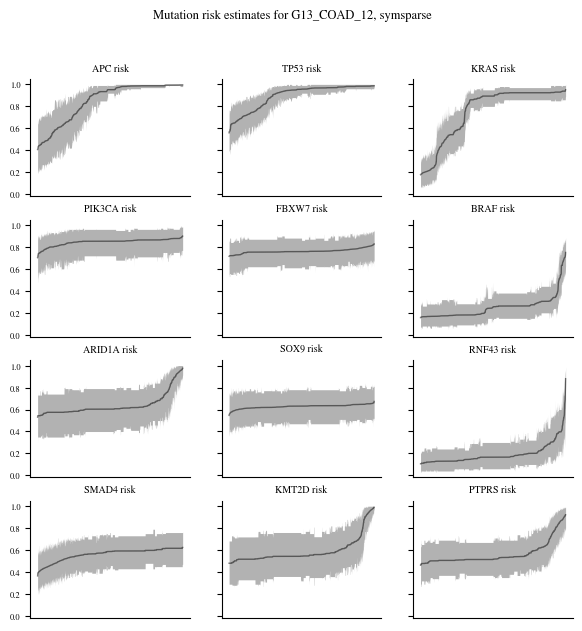

In [59]:
fig, ax = plt.subplots(4, 3, figsize=(7, 7), sharey=True)

for event in range(12):
    
    a = ax[event // 3, event % 3]
    
    data_filtered = data[data.iloc[:, event] == 0]
    sorting = None

    risk = risks[data_filtered.index, :, event]
    sorting = np.argsort(risk.mean(axis=1))
    a.plot(risk.mean(axis=1)[sorting], lw=1, alpha=0.5, color="black")
    a.fill_between(
        np.arange(risk.shape[0]),
        np.percentile(risk, 5, axis=1)[sorting],
        np.percentile(risk, 95, axis=1)[sorting],
        alpha=0.3, color="black", lw=0)
    a.set_title(f"{data.columns[event]} risk")
    for side in ["top", "right"]:
        a.spines[side].set_visible(False)
    a.set_xticks([])
fig.suptitle(f"Mutation risk estimates for {data_name}, symsparse", fontsize=9)

## Risks Predicted by the Different Modes of the L1 Posteriors

In [60]:
data_name = "G13_LUAD_12"

samples = np.load("../results/mcmc/G13_LUAD_12_l1_MALA_0_001.npy" if data_name == "G13_LUAD_12"
                  else "../results/mcmc/G13_COAD_12_l1_MALA_0_001421875.npy")[:, ::10]
samples = samples[int(len(samples)*burn_in):]
samples = samples.reshape((-1, samples.shape[-1]))

data = pd.read_csv(f"../data/{data_name}.csv")

In [61]:
n_components = 3
clusterable_embedding = umap.UMAP(
    n_components=n_components).fit_transform(samples)
labels = HDBSCAN(
    min_samples=10,
    min_cluster_size=100,
).fit_predict(clusterable_embedding)
standard_embedding = PCA(n_components=n_components).fit_transform(samples)
clustered = (labels >= 0)

In [62]:
unique_labels = np.unique(labels)
unique_labels = unique_labels[unique_labels != -1]

In [63]:
risks = {
    label: analysis.event_risks(
        samples[labels == label],
        data=data,
        n_samples=100
    )
    for label in np.unique(labels) if label != -1
}

Text(0.5, 0.98, 'Mutation risk estimates for G13_LUAD_12')

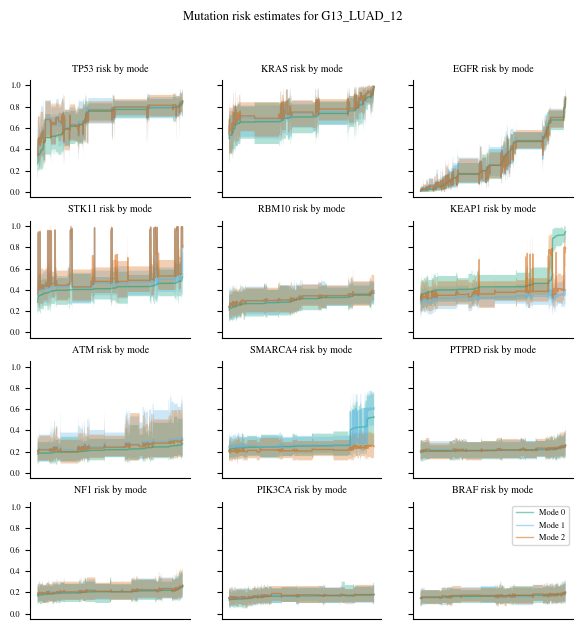

In [71]:
fig, ax = plt.subplots(4, 3, figsize=(7, 7), sharey=True)

for event in range(12):
    
    a = ax[event // 3, event % 3]
    
    data_filtered = data[data.iloc[:, event] == 0]
    sorting = None

    for label in unique_labels:
        

        risk = risks[label][data_filtered.index, :, event]
        if label == -1:
            continue
        if sorting is None:
            sorting = np.argsort(risk.mean(axis=1))
        a.plot(risk.mean(axis=1)[sorting], label=f"Mode {label}", lw=1, alpha=0.5)
        a.fill_between(
            np.arange(risk.shape[0]),
            np.percentile(risk, 5, axis=1)[sorting],
            np.percentile(risk, 95, axis=1)[sorting],
            alpha=0.3,)
    a.set_title(f"{data.columns[event]} risk by mode")
    for side in ["top", "right"]:
        a.spines[side].set_visible(False)
    a.set_xticks([])
ax[-1, -1].legend()
fig.suptitle(f"Mutation risk estimates for {data_name}", fontsize=9)
    
